# Data Science Fundamentals 5

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Science IT Support, University Of Bern, 2020

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Part 1.

In [0]:
from sklearn import linear_model

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics

from matplotlib import  pyplot as plt
import numpy as np
from imageio import imread
import pandas as pd
from time import time as timer

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

# What is Machine learning?

Unlike classical algorithms, created by human to analyze some data:

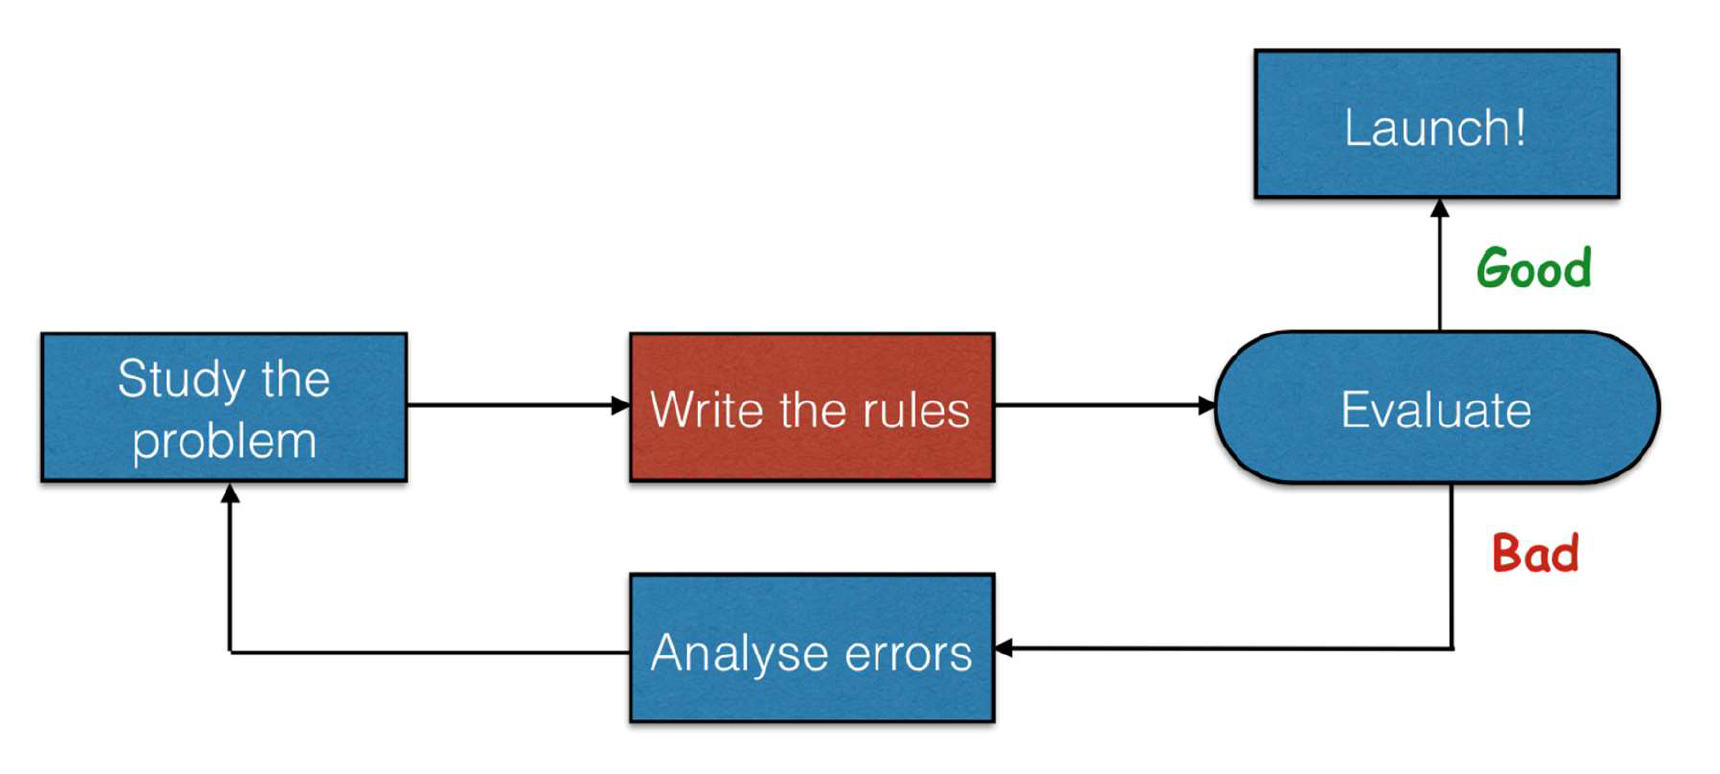

in machine learning the data itself is used for to define the algorithm:

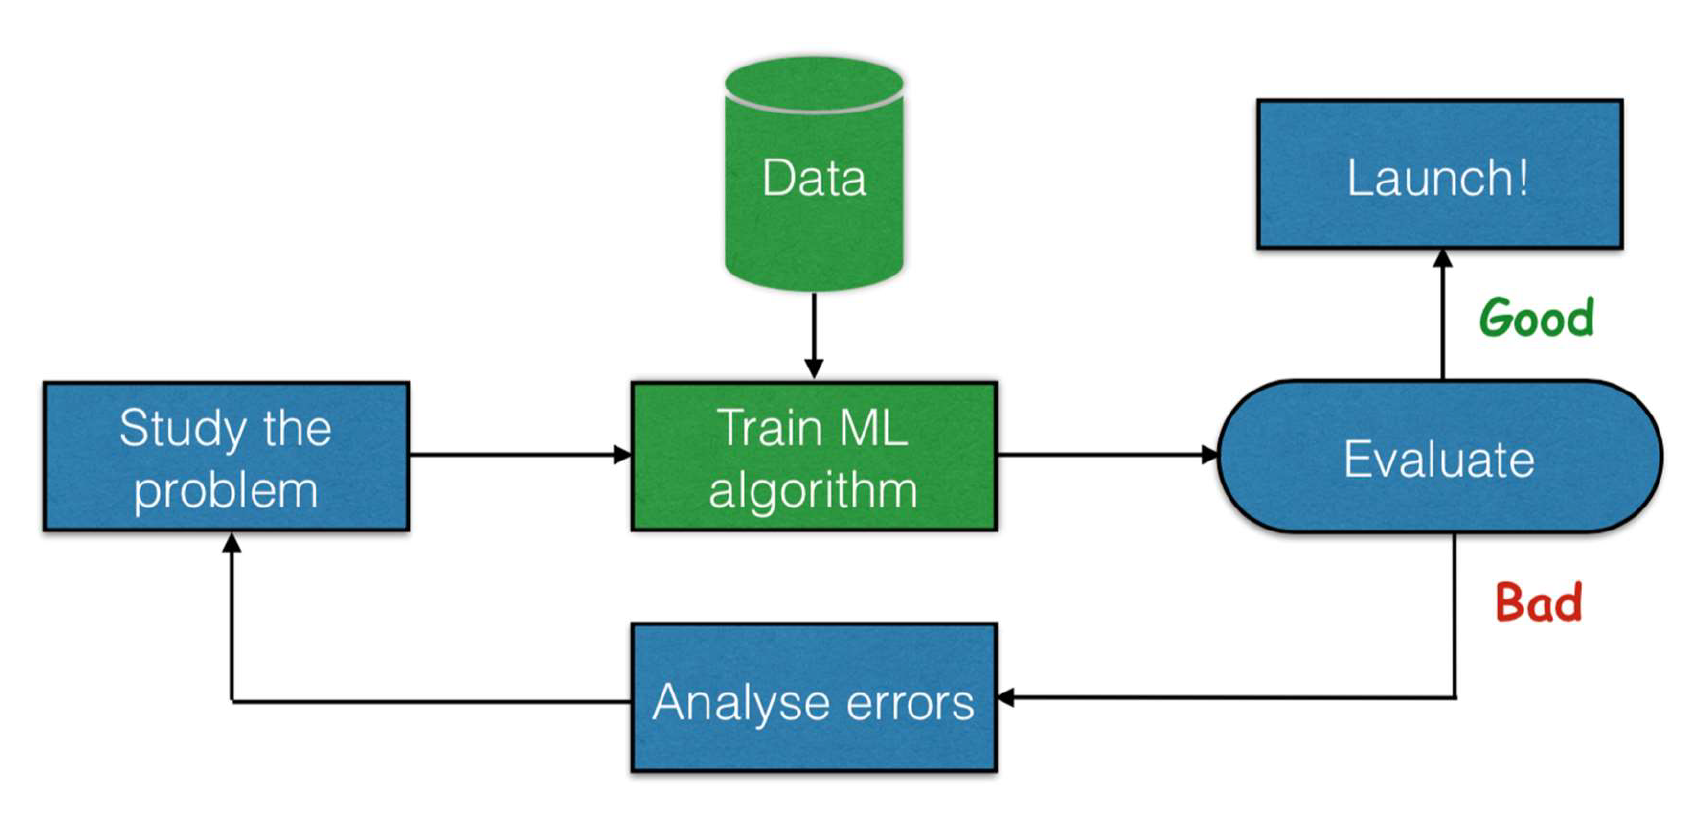

ML:
* improves performance according to measure **P**
* on a task **T**
* with experience **E**



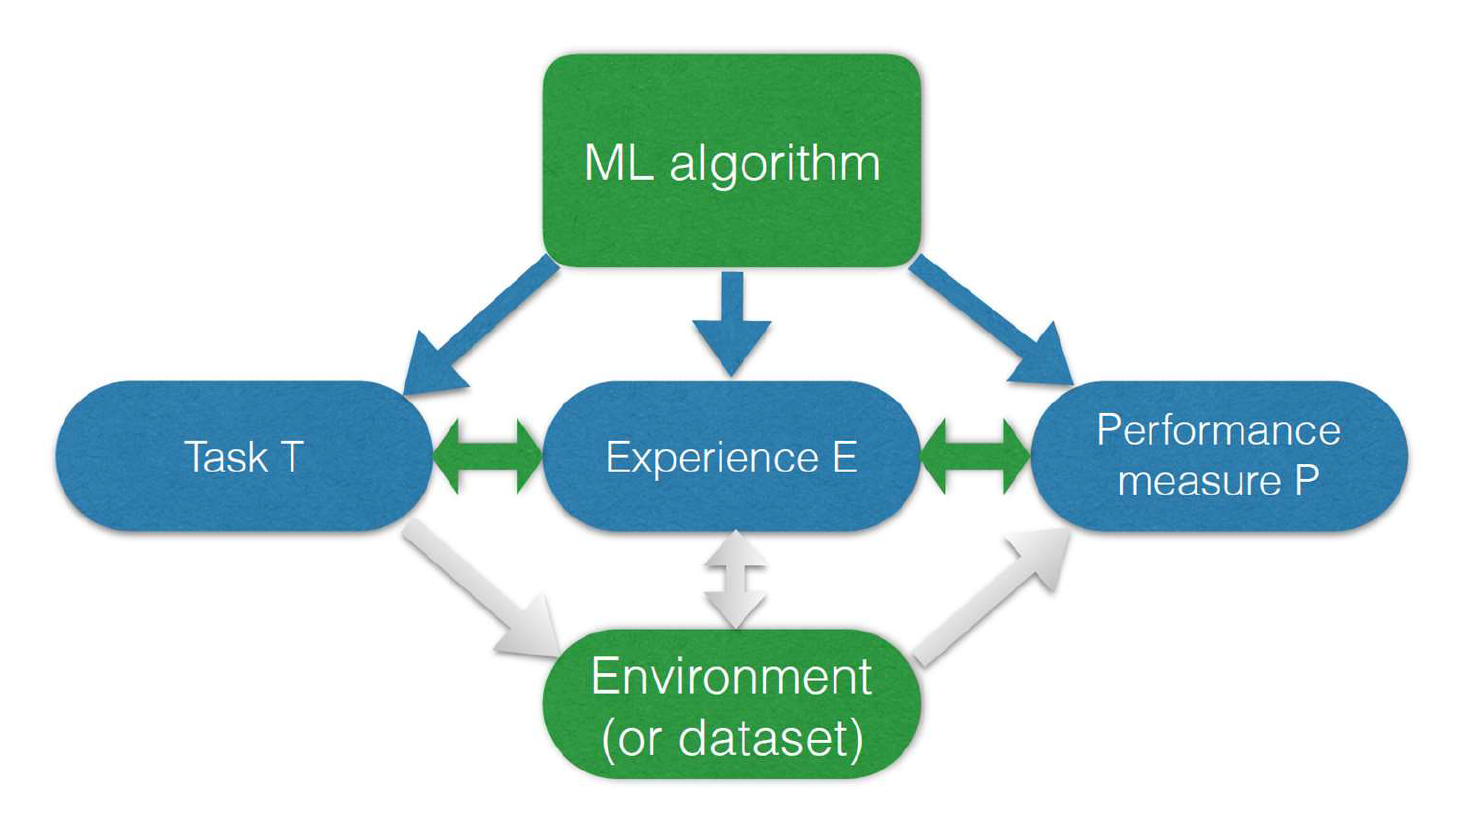


The boundary is a bit fuzzy.
In fact when we create algorithms, the problem in hand, namely the data  related to the problem, drives us to chose one or another algorithm. And we then tune it, to perform well on a task in hand. ML formalized this procedure, allowing us to automate (part) of thise process.

In this 2-day course you will get acquainted with the basics of ML, where the approach to handling the data (the algorithm) is defined, or as we say "learned" from data in hand.

## Classification vs regression.

The two main tasks handled by (supervised) ML is regression and classification.
In regression we aim at modeling the relationship between the system's response (dependent variable) and one or more explanatory variables (independent variables).

Examples of regression would be predicting the temperature for each day of the year, or expenses of the household as a function of the number of children and adults.

In classification the aim is to identify what class does a data-point belong to. For example the spieces or the iris plant based on the size of it's petals, or whether an email is spam or not based on it's content.

## Performance measures


1. Regression:
* Mean Square Error (MSE): $mse=\frac{1}{n}\sum_i(y_i - \hat y(\bar x_i))^2$
* Mean Absolute Error (MAE): $mae=\frac{1}{n}\sum_i|y_i - \hat y(\bar x_i)|$
* Median Absolute Deviation (MSE): $mse=median(|y_i - \hat y(\bar x_i)|)$
* Fraction of the explained variance: $R^2=1-\frac{\sum_i(y_i - \hat y(\bar x_i))^2}{\sum_i(y_i - \bar y_i)^2}$, where $\bar y=\frac{1}{n}\sum_i y_i$

2. Classification:
* Confusion matrix 


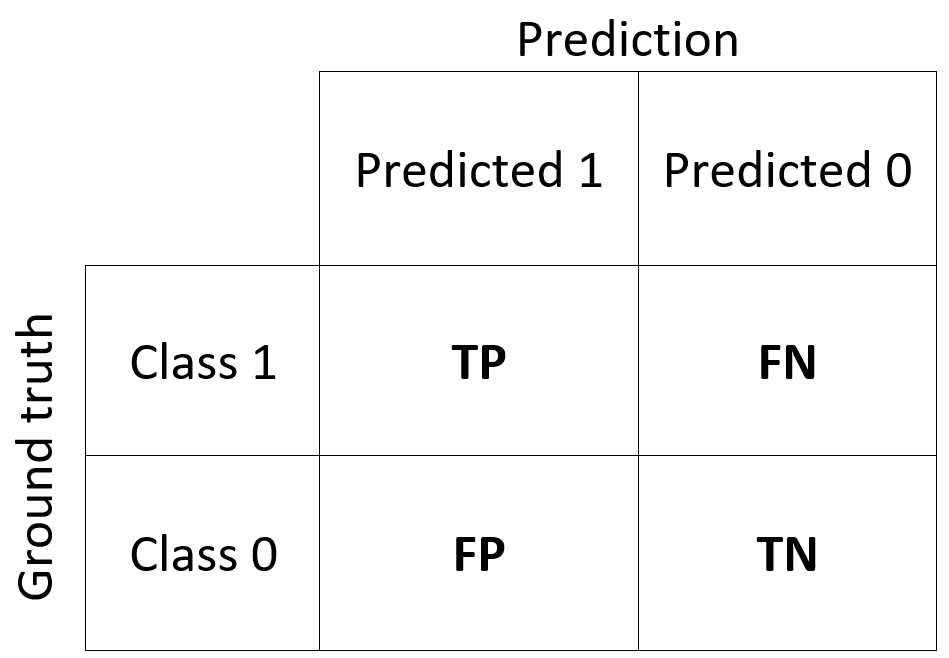

* Accuracy $=\frac{TP+TN}{TP+FP+FN+TN}$
* Precision $=\frac{TP}{TP+FP}$
* Recall $=\frac{TP}{TP+FN}$
* F1 $=2\frac{Precision \cdot Recall}{Precision+Recall} = \frac{2 TP}{2 TP + FP+FN}$
* Threat score(TS), or Intersection over Union (IoU): IoU=$\frac{TP}{TP+FN+FP}$

During model optimization the used measure in most cases must be differentiable. To this end usually some measure of similarities of diestributions are employed (e.g. cross-entropy).

## Actual aim: Generalization

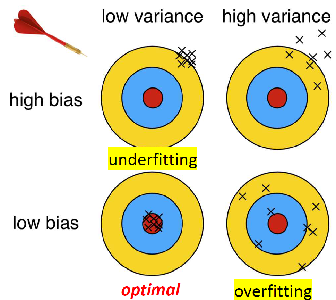

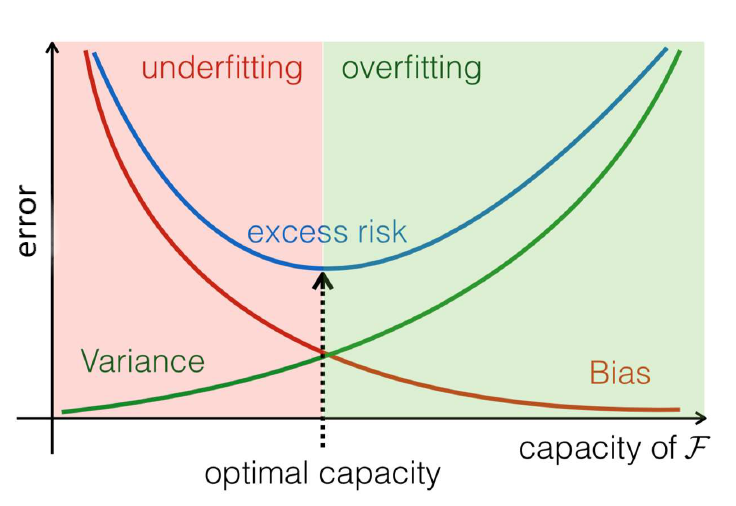

To measure model performace in an unbiassed way, we need to use different data than the data that the model was trained on. For this we use the 'train-test' split: e.g. 20% of all available dataset is reserved for model performance test, and the remaining 80% is used for actual model training.

# Datasets

In this course we will use several synthetic and real-world datasets to ilustrate the behavior of the models and excercise our skills.

## 1. Synthetic linear

In [0]:
def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))
  
  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true w =', w, ';  b =', b)

  return x, y

true w = [7.74138915] ;  b = -5.420841006327979


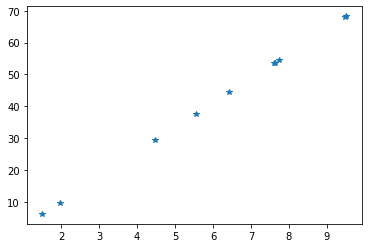

In [0]:
x, y = get_linear(n_d=1, sigma=0)
plt.plot(x[:, 0], y, '*')

true w = [2.4839358  3.88817999] ;  b = -0.40605915588519537


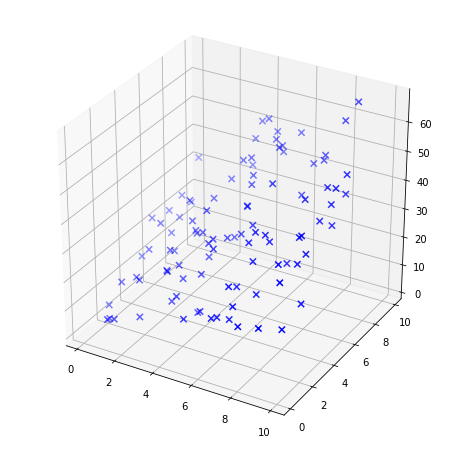

In [0]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=40)

# xx0 = np.linspace(x[:,0].min(), x[:,0].max(), 10)
# xx1 = np.linspace(x[:,1].min(), x[:,1].max(), 10)
# xx0, xx1 = [a.flatten() for a in np.meshgrid(xx0, xx1)]
# ax.plot_trisurf(xx0, xx1, [5]*len(xx0), alpha=0.5, color='g') 


## 2. House prices

Subset of the the hous pricess kaggle dataset: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [0]:
def house_prices_dataset(return_df=False, price_max=400000, area_max=40000):
  df = pd.read_csv('train.csv', na_values="NaN", keep_default_na=False)

  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  cleanup_nums = {"Street":      {"Grvl": 0, "Pave": 1},
                  "LotFrontage": {"NA":0},
                  "Alley":       {"NA":0, "Grvl": 1, "Pave": 2},
                  "LotShape":    {"IR3":0, "IR2": 1, "IR1": 2, "Reg":3},
                  "Utilities":   {"ELO":0, "NoSeWa": 1, "NoSewr": 2, "AllPub": 3},
                  "LandSlope":   {"Sev":0, "Mod": 1, "Gtl": 3},
                  "ExterQual":   {"Po":0, "Fa": 1, "TA": 2, "Gd": 3, "Ex":4},
                  "ExterCond":   {"Po":0, "Fa": 1, "TA": 2, "Gd": 3, "Ex":4},
                  "BsmtQual":    {"NA":0, "Po":1, "Fa": 2, "TA": 3, "Gd": 4, "Ex":5},
                  "BsmtCond":    {"NA":0, "Po":1, "Fa": 2, "TA": 3, "Gd": 4, "Ex":5},
                  "BsmtExposure":{"NA":0, "No":1, "Mn": 2, "Av": 3, "Gd": 4},
                  "BsmtFinType1":{"NA":0, "Unf":1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ":5, "GLQ":6},
                  "BsmtFinType2":{"NA":0, "Unf":1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ":5, "GLQ":6},
                  "HeatingQC":   {"Po":0, "Fa": 1, "TA": 2, "Gd": 3, "Ex":4},
                  "CentralAir":  {"N":0, "Y": 1},
                  "Electrical":  {"NA":0, "Mix":1, "FuseP":2, "FuseF": 3, "FuseA": 4, "SBrkr": 5},
                  "KitchenQual": {"Po":0, "Fa": 1, "TA": 2, "Gd": 3, "Ex":4},
                  "Functional":  {"Sal":0, "Sev":1, "Maj2": 2, "Maj1": 3, "Mod": 4, "Min2":5, "Min1":6, 'Typ':7},
                  "FireplaceQu": {"NA":0, "Po":1, "Fa": 2, "TA": 3, "Gd": 4, "Ex":5},
                  "PoolQC":      {"NA":0, "Fa": 1, "TA": 2, "Gd": 3, "Ex":4},
                  "Fence":       {"NA":0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv":4},
                  }

  df_X = df[useful_fields].copy()                              
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else (x,y)

In [0]:
x, y, df = house_prices_dataset(return_df=True)
print(x.shape, y.shape)
df.head()

(1420, 24) (1420,)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000


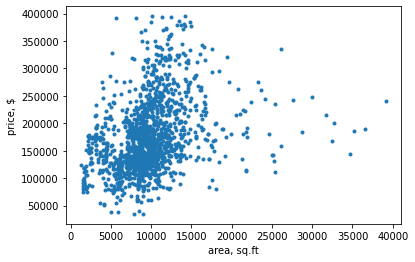

In [0]:
plt.plot(x[:, 0], y, '.')
plt.xlabel('area, sq.ft')
plt.ylabel('price, $');

## 3. Blobs

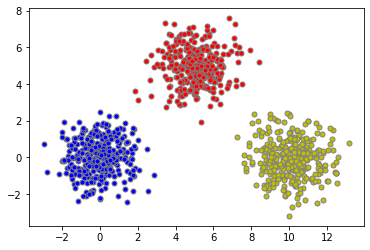

In [0]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])
colors = "bry"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)

## 4. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Let's chech few samples:

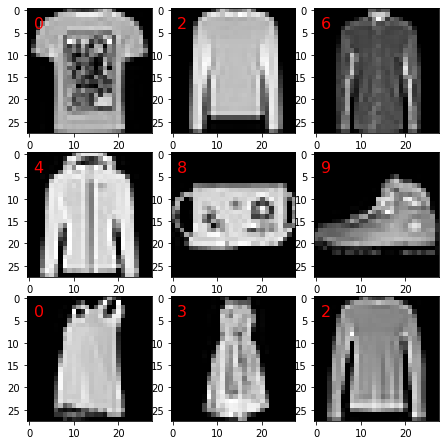

In [0]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
plt.tight_layout(0,0,0)

Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

# 0. `scikit-learn` interface

* In this session we wil use the `scikit-learn` module 
* Interface description: same methods


# 1.Linear models

In many cases the the scalar value of interest - dependent variable - is (or can be aproximated as) linear combination of the independent variables. 

In linear regression the estimator is searched in the form: $$\hat{y}(w, x) = w_0 + w_1 x_1 + ... + w_p x_p$$

The parameters $w = (w_1,..., w_p)$ and $w_0$ are designated as `coef_` and `intercept_` in `sklearn`.

Reference: https://scikit-learn.org/stable/modules/linear_model.html

## 1. Linear regression

LinearRegression fits a linear model with coefficients $w = (w_1,..., w_p)$ and $w_0$ to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. Mathematically it solves a problem of the form: $$\min_{w} || X w - y||_2^2$$

true w = [7.1822562] ;  b = 9.79476370936521


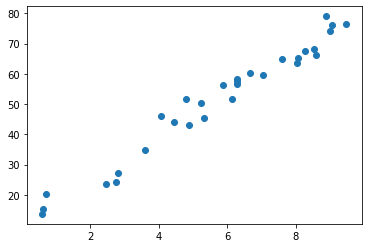

In [0]:
x, y = get_linear(n_d=1, sigma=3, n_points=30)  # p==1, 1D input
plt.scatter(x, y);

In [0]:
reg = linear_model.LinearRegression()
reg.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
w, w0 = reg.coef_, reg.intercept_
print(w, w0)

[7.01934137] 11.053372857838298


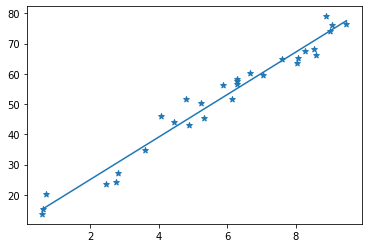

In [0]:
plt.scatter(x, y, marker='*')
x_f = np.linspace(x.min(), x.max(), 10)
y_f = w0 + w[0] * x_f
plt.plot(x_f, y_f)

In [0]:
# mse
np.std(y - reg.predict(x))  # or use metrics.mean_squared_error(..., squared=False)

3.3586622366860324

In [0]:
# R2
reg.score(x, y) 

0.9672346421678027

Let's try 2D input:

true w = [1.70184279 3.97336629] ;  b = -4.077873717148481


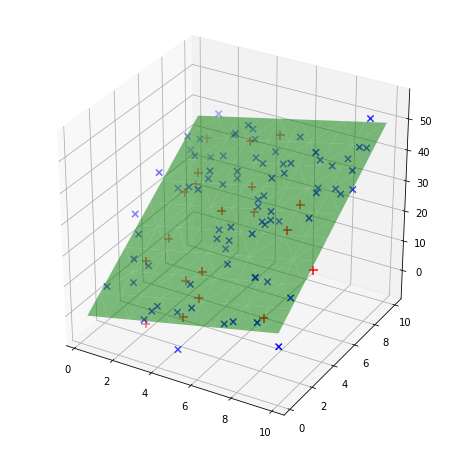

In [0]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100, sigma=5)

# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train[:,0], x_train[:,1], y_train, marker='x', color='b',s=40)
ax.scatter(x_test[:,0], x_test[:,1], y_test, marker='+', color='r',s=80)

xx0 = np.linspace(x[:,0].min(), x[:,0].max(), 10)
xx1 = np.linspace(x[:,1].min(), x[:,1].max(), 10)
xx0, xx1 = [a.flatten() for a in np.meshgrid(xx0, xx1)]
xx = np.stack((xx0, xx1), axis=-1)
yy = reg.predict(xx)
ax.plot_trisurf(xx0, xx1, yy, alpha=0.5, color='g');


In [0]:
# mse
print('train mse =', np.std(y_train - reg.predict(x_train)))
print('test mse =', np.std(y_test - reg.predict(x_test)))

train mse = 5.027923681092308
test mse = 4.883713115804585


In [0]:
# R2
print('train R2 =', reg.score(x_train, y_train))
print('test R2 =', reg.score(x_test, y_test))

train R2 = 0.8307475755432112
test R2 = 0.8117146899591664


## EXERCISE 1.

Use linear regression to fit house prices dataset.

In [0]:
x, y = house_prices_dataset()

# 1. make train/test split

# 2. fit the model

# 3. evaluate MSE, MAD, and R2 on train and test datasets

# 4. plot y vs predicted y for test and train parts

## 2. Logistic regression

Logistic regression, despite its name, is a linear model for classification rather than regression. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

In logistic regression the probability $p$ of a point belonging to a class is modeled as: $$\frac{p}{1-p} = e^{w_0 + w_1 x_1 + ... + w_p x_p}$$

The binary class $\ell_2$ penalized logistic regression minimizes the following cost function:
$$\min_{w, c} \frac{1}{2}w^T w + C \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1)$$.

training accuracy : 0.995 (multinomial)


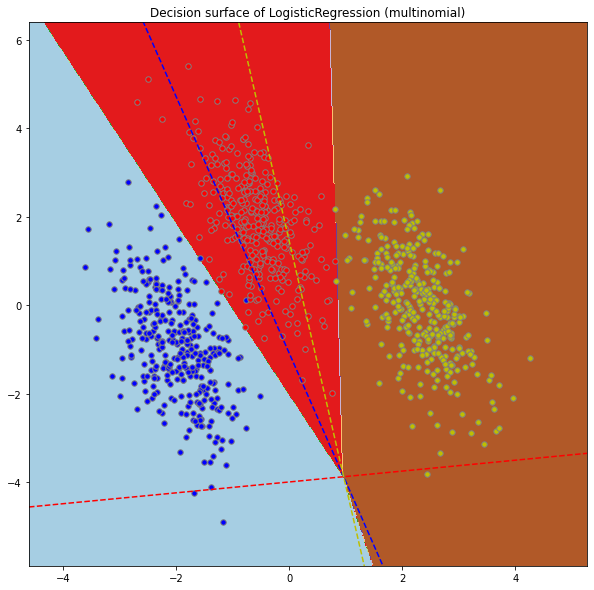

training accuracy : 0.976 (ovr)


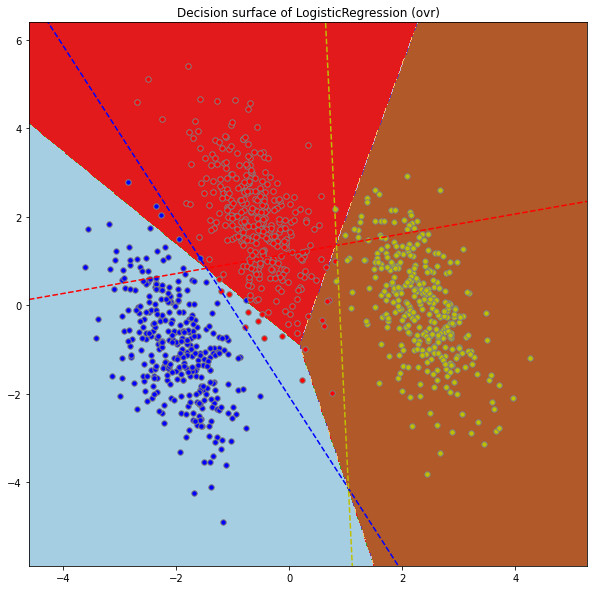

In [0]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
x, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
x = np.dot(x, transformation)

for multi_class in ('multinomial', 'ovr'):
    clf = linear_model.LogisticRegression(solver='sag', max_iter=100,
                             multi_class=multi_class)
    clf.fit(x, y)

    # print the training scores
    print("training accuracy : %.3f (%s)" % (clf.score(x, y), multi_class))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    z = z.reshape(xx.shape)
    plt.figure(figsize=(10,10))
    plt.contourf(xx, yy, z, cmap=plt.cm.Paired)
    plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
    plt.axis('tight')

    # Plot also the training points
    colors = "bry"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(x[idx, 0], x[idx, 1], c=color, cmap=plt.cm.Paired, 
                    edgecolor='gray', s=30)

    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_

    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                 ls="--", color=color)

    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)

    plt.show()

## EXERCISE 2.

In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

We will reshape 2-d images to 1-d arrays for use in scikit-learn:

In [0]:
n_train = len(train_labels)
x_train = train_images.reshape((n_train, -1))
y_train = train_labels

n_test = len(test_labels)
x_test = test_images.reshape((n_test, -1))
y_test = test_labels

In [0]:
multi_class = 'multinomial'
clf = linear_model.LogisticRegression(solver='sag', max_iter=20,
                                      multi_class=multi_class)
t1 = timer()
clf.fit(x_train, y_train)
t2 = timer()
print ('training time: %.1fs'%(t2-t1))
# print the training scores
print("training score : %.3f (%s)" % (clf.score(x, y), multi_class))
print("test score : %.3f (%s)" % (clf.score(xt, yt), multi_class))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


training time: 40.5s
training score : 0.874 (multinomial)
test score : 0.843 (multinomial)
